/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring_staging/20181113
Reading SDR_SpectrumPeak.20181113-060000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-180000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-020000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-160000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-000000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-220000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-140000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-120000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-080000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-040000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-100000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-200000.n240.None.ridz
Data span 2018-11-13 00:00:00 - 2018-11-13 23:59:30


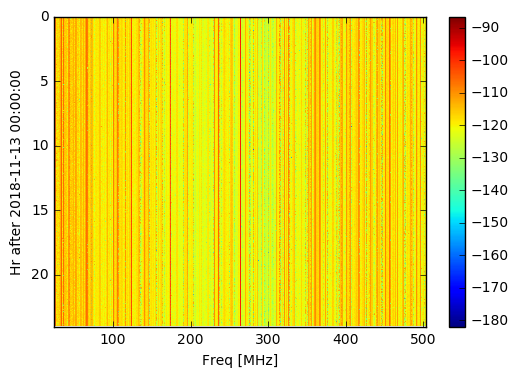

Reading SDR_SpectrumPeak.20181113-060000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-180000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-020000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-160000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-000000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-220000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-140000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-120000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-080000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-040000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-100000.n240.None.ridz
Reading SDR_SpectrumPeak.20181113-200000.n240.None.ridz
Data span 2018-11-13 00:00:00 - 2018-11-13 23:59:30


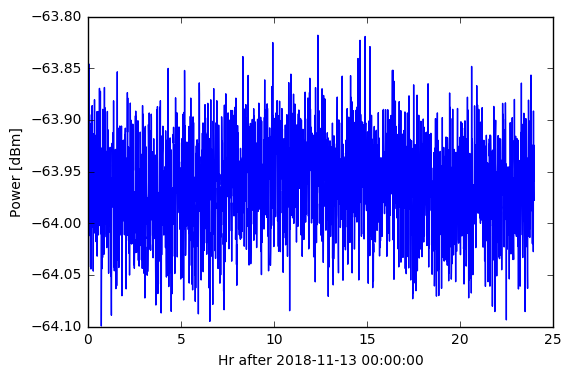

In [1]:
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import os
import json
import subprocess

OUT_DAY = 'arr_day.npy' #the output files containing integrated power and metadata for each sweep-spectrum on record
OUT_NIGHT = 'arr_night.npy'
SUNSET_TIMETABLE = np.genfromtxt('/lustre/aoc/projects/hera/ajosaiti/SDR_RFI_monitoring/HERA_daily_RFI/HERA_sunrise_sunset_annual.csv', dtype=str,delimiter=',') # Col 0: Month-day (mmdd), Col 1: Sunrise (hhmm), Col 2: Sunset (hhmm)
STR_DAY = os.environ['which_day']
DEBUG = bool(int(os.environ['DEBUG'])) #False

def file_flush():
	if DEBUG: print('flushing temporary and output files...')
	open(OUT_DAY, 'w').close()
	open(OUT_NIGHT, 'w').close()
	if DEBUG: print('done.')

def delta_hours_minutes(td):
    return td.seconds//3600, (td.seconds//60)%60

def recursive_key_search(dat, key): #https://stackoverflow.com/questions/9807634/find-all-occurrences-of-a-key-in-nested-python-dictionaries-and-lists
#sum_dbm_recursive_key_search(dat, key): #https://stackoverflow.com/questions/9807634/find-all-occurrences-of-a-key-in-nested-python-dictionaries-and-lists
    if key in dat:
        yield dat[key]
    for k in dat:
        if isinstance(dat[k], list):
            for i in dat[k]:
                for j in recursive_key_search(i):
                    yield j

def time_in_rids_fmt(datetime_time): # convert datetime.datetime.now() time into the RIDZ-requested format
	str_iso = datetime_time.isoformat(' ')
	str_time_rids = str( str_iso[0:4] + str_iso[5:7] + str_iso[8:10] + '-' + str_iso[11:13]+str_iso[14:16]+str_iso[17:19])
	return str_time_rids

def sum_array_of_dbm(arr):
	val_sum = 10.*np.log10(np.sum(np.power(10,np.array(arr)/10.)))
	return val_sum

def trunc_time(dt):
    dt_trunc = datetime.date(dt.day, dt.hour, dt.minute, dt.second)
    return dt_trunc

def calc_wf_and_integrated_power(sunrise, sunset):
    ## check these fileid aren't in the processed_sessid.txt file
    processed_file_dir = os.path.dirname(os.environ['DATA_PATH'])
    processed_fileid = np.loadtxt(os.path.join(processed_file_dir, 'processed_fileid.txt'), dtype=np.int)
    if DEBUG: 
        print('NOTE: Since in DEBUG mode, Will reprocess files if instructed.')
        
    # filter out sessions already processed
    unprocessed_files = []
    pathname = []
    for diritem in os.listdir(os.environ['staging_dir']):
        if DEBUG: 
            print('in ipynb, staging_dir is: '+str(os.environ['staging_dir']))
        if os.path.isdir(diritem) or str(diritem).isdigit():
            pathname = str(str(os.environ['staging_dir'])+'/'+str(diritem)+'/')
            print('  '+str(diritem)+' considered to be a dir.')
            for dir_file in os.listdir(pathname):
                name=str(dir_file)#file["name"])
                if DEBUG: print('   In dir, pathname: '+str(pathname)+', dirfile: '+str(name))
                fileid = int(name[int(name.find('.')+1):name.find('-')])
                if (fileid not in processed_fileid) or DEBUG:
                    unprocessed_files.append(name)
                    
        else:
            pathname = str(os.environ['staging_dir']+'/')
            name=str(diritem)#file["name"])
            if DEBUG: 
                print('  '+str(name)+' is thought to be a file, not a directory.')
                print('    diritem is a file, name: '+str(name))
            fileid = int(name[int(name.find('.')+1):name.find('-')])
            if (fileid not in processed_fileid) or DEBUG:
                unprocessed_files.append(name)

    if DEBUG: 
        print('List of unprocessed files (or all files if DEBUG): '+str(unprocessed_files))
        print('Ready to analyze files in pathname "'+str(pathname)+'".')
        print('launching subprocess...')
    %cd {pathname}
    str_args = str( str( ','.join([str(s) for s in os.listdir(pathname) if s.endswith('.ridz') and STR_DAY in s and os.stat(s).st_size !=0])))
    if DEBUG: print('str_args: '+str(str_args))
    %run /users/ajosaiti/anaconda/envs/py2.7env/rids/scripts/sp_rawview.py --wf val {str_args}
    %run /users/ajosaiti/anaconda/envs/py2.7env/rids/scripts/sp_rawview.py --totalpower val {str_args}
    if DEBUG: print('    ...subprocess complete.')

    return pathname 

#For the day in question, figure out when sunset and sunrise were. 
col_date,col_key = np.where(SUNSET_TIMETABLE == STR_DAY[4:]) #find mmdd, but it could also be a time
sunrise = datetime.datetime.strptime( str(str(STR_DAY[:4])+str(STR_DAY[4:])+'-'+str(SUNSET_TIMETABLE[int(col_date[col_key==0])][1])) ,'%Y%m%d-%H%M')
sunset = datetime.datetime.strptime( str(str(STR_DAY[:4])+str(STR_DAY[4:])+'-'+str(SUNSET_TIMETABLE[int(col_date[col_key==0])][2])) ,'%Y%m%d-%H%M')
delta_hour, delta_minute = delta_hours_minutes((sunset-sunrise))
if DEBUG: 
    print( 'Sunrise and sunset objects have type '+str(str(type(sunrise))+', '+str(type(sunset))) )
    print( 'Sunrise: '+str(sunrise)+', Sunset: '+str(sunset))
    #print( 'Sunrise hour: '+str(sunrise.hour))
#Arrays containing data from each sweep measurement, sorted by whether the data occured in the daytime or nighttime.
arr_day=[] # [datetime.datetime object], [float(integrated power)]
arr_night=[]


file_flush() # Make sure output files aren't reused with old data in them.
pathname = calc_wf_and_integrated_power(sunrise, sunset)

#create pathname environment variable so I can add librarian events in run_notebook.sh. This pathname may be different than the staging_dir var.
os.environ['staging_pathname']=pathname
#%env staging_pathname=pathname
